# Machine Learning - EL 9123
## Corrado Mancini
### <h1><center>Higgs Boson Kaggle Competition</center></h1>
![title](ATLASEXP_image.png)

### Kaggle Competition https://www.kaggle.com/c/higgs-boson

The ATLAS experiment at CERN observes signals of the Higgs boson's existence through it's decay into two tau particles. This signal is hard to pick up due to background noise.

#### Main Goal: Predict signals from background noise.

##### Other Goals:
Analyze features and clean up data  
Investigate and determine AUC of ROC  
Compare Logistic Regression results for different methods of processing data  
Investigate Gradient Boosted Tree models through Microsoft's LightGBM  

In [257]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import linear_model, preprocessing
from scipy import interp

import lightgbm as lgb

## Load Data

### Load Training Data

250000 Events  
30 Features  
2 Classes  
Signal events are labeled as 's'  
Background events are labeled as 'b'


In [258]:
df_train = pd.read_csv('training.csv')

df_train.head(6)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,6.245333,b
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660,0.083414,b


Meaningless data is labeled as -999. This data will be explained in more detail later on.   
Right now we should note that there are multiple ways of dealing with this data.
First we will try removing these events.

In [259]:
# Remove placeholder for linear models
df_train_no_na = df_train[df_train != -999].dropna()

print('Number of events remaining: {}'.format(df_train_no_na.shape[0]))


Number of events remaining: 68114


Removing close to 1/3 of the data is probably unacceptable.

We will try analyzing with the original -999 values and also replacing those values with the feature mean.

In [260]:
# Replace placeholder with mean
df_train_rep_na = df_train[df_train != -999].fillna(df_train[df_train != -999].mean())

Before moving on to doing some actual machine learning we should load the test data. This data is not labeled as signal or background and predictions on this data can only be scored by submitting a solution file with predictions to Kaggle's website.   

This competition ranks competitors by determining an AMS metric score. This score uses the s/b rates predetermined by the physicists. Because this metric is not widespread in machine learning it was not calculated in the project. However a submission score for my best model will be shown at the end of the project.
![title](AMS_Metric.png)

### Load Test Data

550000 events

In [261]:
df_test = pd.read_csv('test.csv')

# Show
df_test.head(6)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213
5,350005,95.709,94.168,66.280,14.719,-999.000,-999.000,-999.000,3.065,14.719,...,2.566,86.129,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000


### Convert training data into numpy arrays

In [262]:
# Set s = 1, b = 0
yraw = np.array(df_train['Label'])
y = np.array(yraw == 's').astype(int)

# Data directly from dataframe with -999 values
X = np.array(df_train.iloc[:,1:-2])

# Data replacing -999 values with mean
X_rep_na = np.array(df_train_rep_na.iloc[:,1:-2])

Let's run some simple logistic regression and check our model's accuracy.  
No cross-validation yet! Just trying to see what we are working with here.

In [263]:
# With -999 values in the data
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)
yhat1 = logreg.predict(X)

acc1 = np.mean(yhat1 == y)

# Replaced -999
logreg = linear_model.LogisticRegression()
logreg.fit(X_rep_na, y)
yhat2 = logreg.predict(X_rep_na)

acc2 = np.mean(yhat2 == y)


print("Accuracy on training data with -999 = {:.5}".format(acc1))
print("Accuracy on training data with -999 replaced with mean = {:.5}".format(acc2))


Accuracy on training data with -999 = 0.75011
Accuracy on training data with -999 replaced with mean = 0.7505


Neither method gives a particularly exciting result. Analyzing the features should give us insight on how to proceed.

##### Analyzing the Data

Any meaningless features have a value of -999. Looking at the data it can be seen that there is some order to when certain features have meaningless data.

PRI_jet_num determines which PRI_jet features are meaningless. This can be seen in a plot of PRI_jet_num vs # of meaningless features.

[-1, 4, -1, 13]

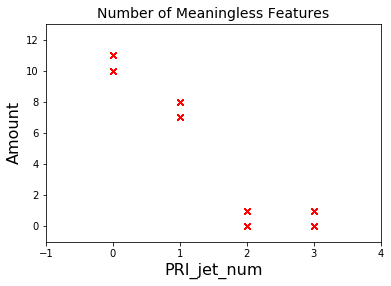

In [264]:
# Plot number of meaningless features vs PRI_jet_num

plt.plot(df_train['PRI_jet_num'], df_train[ df_train != -999].isnull().sum(axis=1),'rx')
plt.xlabel('PRI_jet_num', fontsize=16)
plt.ylabel('Amount', fontsize=16)
plt.title('Number of Meaningless Features', fontsize=14)
plt.axis([-1,df_train['PRI_jet_num'].max()+1,-1, 13])

The reason there is N or N + 1 meaningless features for each PRI_jet_num is that DER_mass_MMC also sometimes meaningless.

This plot shows that events can be probably be binned by PRI_jet_num and trainned on separate models

In [266]:
# Bin X data by PRI_jet_num and drop nulls
X0 = np.array(df_train[df_train['PRI_jet_num']==0][df_train[df_train['PRI_jet_num']==0] != -999].dropna(axis=1).iloc[:,1:-2])
X1 = np.array(df_train[df_train['PRI_jet_num']==1][df_train[df_train['PRI_jet_num']==1] != -999].dropna(axis=1).iloc[:,1:-2])
X2 = np.array(df_train[df_train['PRI_jet_num']==2][df_train[df_train['PRI_jet_num']==2] != -999].dropna(axis=1).iloc[:,1:-2])
X3 = np.array(df_train[df_train['PRI_jet_num']==3][df_train[df_train['PRI_jet_num']==3] != -999].dropna(axis=1).iloc[:,1:-2])

# Bin Y data by PRI_jet_num and drop nulls
yraw = np.array(df_train[df_train['PRI_jet_num']==0]['Label'])
y0 = np.array(yraw == 's').astype(int)
yraw = np.array(df_train[df_train['PRI_jet_num']==1]['Label'])
y1 = np.array(yraw == 's').astype(int)
yraw = np.array(df_train[df_train['PRI_jet_num']==2]['Label'])
y2 = np.array(yraw == 's').astype(int)
yraw = np.array(df_train[df_train['PRI_jet_num']==3]['Label'])
y3 = np.array(yraw == 's').astype(int)


In [268]:
# Train first set of data
logreg0 = linear_model.LogisticRegression()
logreg0.fit(X0, y0)
probas0 = logreg0.predict_proba(X0)
yhat0 = logreg0.predict(X0)

# Train second set of data
logreg1 = linear_model.LogisticRegression()
logreg1.fit(X1, y1)
probas1 = logreg1.predict_proba(X1)
yhat1 = logreg1.predict(X1)

# Train third set of data
logreg2 = linear_model.LogisticRegression()
logreg2.fit(X2, y2)
probas2 = logreg2.predict_proba(X2)
yhat2 = logreg2.predict(X2)

# Train fourth set of data
logreg3 = linear_model.LogisticRegression()
logreg3.fit(X3, y3)
probas3 = logreg3.predict_proba(X3)
yhat3 = logreg3.predict(X3)

# Stack all predictions and original labels into comparable arrays
yhat_binned = np.hstack([yhat0, yhat1, yhat2, yhat3])
probas_binned =  np.hstack([probas0[:,1], probas1[:,1], probas2[:,1], probas3[:,1], ])
y_binned = np.hstack([y0, y1, y2, y3])


In [269]:

acc_binned = np.mean(yhat_binned == y_binned)
print("Accuracy on binned data = {:.5}".format(acc_binned))


Accuracy on binned data = 0.76481


This might be a little better than before but probably not much.

Let's look at cross-validation and a different metric than accuracy.

## AUC ROC (Receiver Operating Characteristic)

Accuracy measures model performance for a particular threshold, usually 0.5. This threshold determines the binary classification. Area under the curve of the receiver operating characteristics is a more comprehensive measure as it shows how the true positive rate and false positive rate trade off. Because the threshold for this model will be investigated further later on in this project the broader metric of AUC will be used to grade performance

ROC plots true positive rate (TPR) vs false positive rate (FPR). An ideal curve is essentially a square with an area of 1. 
A good way to visualize this metric is with a small amount of data. As the amount of data/events increase the curve smoothens outs. 

We will look at Kfold CV of 500 random samples of the X0 data above. The small number of samples chosen shows the "choppiness" of the curve for different TPR and FPR rates.

Stratified KFold was chosen to keep the s/b ratio similar across all folds.

Note: this code is a combination of code from Kfold CV from the labs of this course and from the scikit-learn website which explains AUC ROC. http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

Precision = 0.4658, SE=0.1565
Recall =    0.3929, SE=0.1584
f1 =        0.4095, SE=0.1472
Accuracy =  0.7200, SE=0.0542


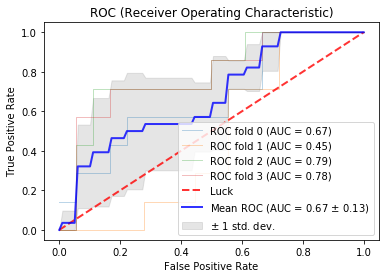

In [273]:
# 500 random samples
nsamp = 500
x = [np.random.randint(0,X0.shape[0]) for p in range(0,100)]

Xs  = X0[x,:]
ys  = y0[x]

# Kfold Cross-validation

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

nfold = 4
kf = StratifiedKFold(n_splits=nfold)
prec = []
rec = []
f1 = []
acc = []
for train, test in kf.split(Xs, ys):            
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = ys[train]
    Xts = Xs[test,:]
    yts = ys[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    probas_ = logreg.predict_proba(Xts)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yts, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

Let's go back and plot the ROC for the binned approach with all features and events. This curve will be much smoother than the one above.

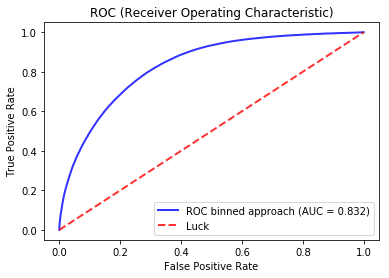

In [272]:
fpr, tpr, thresholds = roc_curve(y_binned, probas_binned)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b',
         label=r'ROC binned approach (AUC = {:.3})'.format(roc_auc),
         lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

We could continue with imporving performance of logistic regression and cross-validation for the binned feature approach however we will move onto the main focus of this project which is gradient boosted trees.

## Gradient Boosted Decision Trees (GBDT)

Decision tree classification is a machine learning technique which makes decisions on input data. Decision trees represent choices between alternative classifications of features as branches in a tree and ultimate event classification with leaf nodes.   
Gradient boosted decision trees are essentially ensemble models of decisions trees. Decision tree models in LightGBM, a GBDT, are trained in sequence and learned by fitting the negative gradient. 

GBDT are good at fitting models with little processing of feature data.

## LightGBM


We will replace -999 values with nulls. This is something LightGBM will be able to work with.

In [274]:
# Data with na replacing -999 values
X_na = np.array(df_train.iloc[:,1:-2])
X_na[X == -999] = float('nan')

We will perform cross-calidation and set our parameters for LightGBM. 
Boosting is a method of sequentially fitting a decision tree model then fitting subsequent decisions trees to the residuals of that model.

The process can be simplified to the steps below. A function F is found on x data and the process is repeated for the residuals from each step.  

1. F1(x) = y
2. h1(x) = y - F1(x)
3. F2(x) = F1(x) + h1(x)  
.  
.  
.    
Fn(x) = Fn-1(x) + hn-1(x)

h is the residuals

Decisions trees naturally have high variance and low bias. Bagging (boostrap aggregating) is a way to decrease variance by generating synthetic data from the training sample. Essentially decision tree models are averaged out every x amount of rounds of boosting. For this model the frequency is chosen to be every 10 rounds.

We set AUC as our metric and .07 as the learning rate or shrinkage. We want to choose a reasonable number of rounds of boosting. We can pick this value based on model performance during cross-validation.

In [275]:
# Set LightGBM parameters
params = {}
params['application'] = 'binary' 
params['boosting'] = 'gbdt'

# Set number of features boosted each round. Helps with speed
params['feature_fraction'] = 0.8
params['bagging_fraction'] = 0.8
params['bagging_freq'] = 10

params['metric'] = ['auc']
params['learning_rate'] = .07

num_round = 700
nfolds = 7

dlgb = lgb.Dataset(X_na, label=y)

# Run Stratified CV.
lgb_cv = lgb.cv(params, dlgb, num_round, nfold = nfolds, verbose_eval=20, stratified=True)



[20]	cv_agg's auc: 0.892095 + 0.00118342
[40]	cv_agg's auc: 0.899638 + 0.00126419
[60]	cv_agg's auc: 0.90416 + 0.00122916
[80]	cv_agg's auc: 0.906679 + 0.00108983
[100]	cv_agg's auc: 0.9082 + 0.00101276
[120]	cv_agg's auc: 0.909136 + 0.000993784
[140]	cv_agg's auc: 0.909632 + 0.000969945
[160]	cv_agg's auc: 0.90998 + 0.0009655
[180]	cv_agg's auc: 0.910228 + 0.000967889
[200]	cv_agg's auc: 0.910475 + 0.000966265
[220]	cv_agg's auc: 0.910591 + 0.000957384
[240]	cv_agg's auc: 0.910727 + 0.000957504
[260]	cv_agg's auc: 0.910841 + 0.000972723
[280]	cv_agg's auc: 0.910934 + 0.00094246
[300]	cv_agg's auc: 0.911028 + 0.000886139
[320]	cv_agg's auc: 0.911112 + 0.000894208
[340]	cv_agg's auc: 0.91119 + 0.000902415
[360]	cv_agg's auc: 0.911255 + 0.000914533
[380]	cv_agg's auc: 0.911308 + 0.000934429
[400]	cv_agg's auc: 0.911283 + 0.000934379
[420]	cv_agg's auc: 0.911315 + 0.000897054
[440]	cv_agg's auc: 0.911341 + 0.000872286
[460]	cv_agg's auc: 0.91135 + 0.000902776
[480]	cv_agg's auc: 0.911341 

Based on the CV results it looks like the model performance plateaus around 600 rounds. This is what we will use for our model.

In [276]:
# Train
num_rounds_train = 600

lgb_model=lgb.train(params,dlgb,num_rounds_train)

ypred_lgbm = lgb_model.predict(X_na)



## Comparing Logistic Regression vs LightGBM

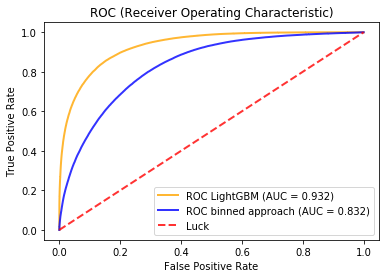

In [277]:
# Calculate AUC and plot ROC for Light GBM
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(y, ypred_lgbm, pos_label=1)
roc_auc_lgbm  = auc(fpr_lgbm,tpr_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm,'orange',label=r'ROC LightGBM (AUC = {:.3})'.format(roc_auc_lgbm),
         lw=2, alpha=.8)


# Calculate AUC and plot ROC for Logistic. (Same code as a few cells above)
fpr, tpr, thresholds = roc_curve(y_binned, probas_binned)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b',
         label=r'ROC binned approach (AUC = {:.3})'.format(roc_auc),
         lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

It's clear from this plot how effective gradient boosted decisions trees can be.  

### Creating a Kaggle Submission

The LightGBM model will be used to predict results from Kaggle's test data. This submission can only be scored by uploading to kaggle.com. 

A variable r was determined as a cutoff to select events as signals with signal probabilities greater than r. According to the competition rules roughly 1/3 of the events in both the training and test set should be signals.  
The AMS metric seems to punish false positives much more than false negatives. As a result of this, my model's cutoff value was optimized through submitting to be around .85. This selects roughly 14% of the events as signals.

In [278]:
print('Percentage of signals in the training data: {:.3}%'.format(100*
                                                                  df_train[df_train['Label'] == 's'].shape[0]/df_train.shape[0]))


Percentage of signals in the training data: 34.3%


In [280]:
r = .85
print('Percentage of signals predicted in the test data after optimizing submission: {:.3}%'.format(100*
    ypred_submission[ypred_submission >r].shape[0]/ypred_submission.shape[0]))

Percentage of signals predicted in the test data after optimizing submission: 14.1%


#### Create sub.csv in Kaggle submission format

In [281]:
r = 0.85

# Load test data into numpy array
test_id = df_test['EventId']

Xtest = np.array(df_test.iloc[:,1:])
Xtest[Xtest == -999] = float('nan')

ypred_submission = lgb_model.predict(Xtest)

sub = pd.DataFrame()
sub['EventId'] = test_id
sub['prob'] = ypred_submission
sub['Class'] = 'b'
sub['Class'].loc[ypred_submission >= r] ='s' 

sub = sub.sort_values('prob')
sub['RankOrder'] = list(range(1,len(sub)+1))
sub.drop('prob',axis=1).to_csv('sub.csv',index=False)


C:\Users\Corrado\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Final Score
The final AMS score of my model is 3.45. The top score was around 3.8!

![title](FinalScore.png)